In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import json
from pprint import pprint

def save_fig(fig, name):
    fig.savefig("graphs/{}.png".format(name), format="png", dpi=500)
    fig.savefig("graphs/{}.pdf".format(name), format="pdf", dpi=500)

In [2]:
def load_json(path):
    with open(path) as f:
        data = json.load(f)
    timings = []
    for d in data["datapoints"]:
        s = d["setting"]
        comp = list(map(lambda x: (x["computationTime"]),
                       sorted(d["data"]["workers"], key=lambda x: x["rank"])))
        comp = max(comp)
        mpi = list(map(lambda x: (x["mpiTime"]),
                       sorted(d["data"]["workers"], key=lambda x: x["rank"])))
        mpi = max(mpi)
        timings.append((comp, mpi, s['nodeCount']))
            
    return timings


In [3]:
def simple_plot(data, title, short_title, alpha=1.):
    cpT, mpiT, nodeCnt = zip(*data)
    x = np.asarray(nodeCnt)
    #  time in s
    cp = np.asarray(cpT) / 1e6
    cp = cp[0] / cp
    mpi = np.asarray(mpiT) / 1e6
    mpi = mpi[0] / mpi


    fig, host = plt.subplots(figsize=(4,4))
    # par1 = host.twinx()
    # diag line
    host.plot(x, x, label="lineare Verbesserung")
    
    host.plot(x, cp, label="max Rechenzeit pro Region", lw=0, marker=".", alpha=alpha)
    host.plot(x, mpi, label="max MPI Zeit pro Region", lw=0, marker=".", alpha=alpha)


        

    host.set(xlabel='Anzahl Rechenknoten', ylabel='Verbesserungsfaktor',
        title=title
    )
    # par1.set(ylabel='max mpi time [s]')

    host.legend()
    host.grid(True)
    #plt.yscale('log')
    #plt.axis([0, 40, 0, 40])

    plt.show()
    #save_fig(fig, short_title)


In [4]:
# Perform linear regression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
import pandas as pd
import math
def regression_plot(data):
    def draw_plot(implementation, ax, fit_color, points_color, label):

        compsorted, itsorted = zip(*sorted(implementation, key=lambda x: x[1]))

        x = sm.add_constant(itsorted)
        y = compsorted
        regr = sm.OLS(y, x)
        res = regr.fit()
        # Get fitted values from model to plot
        # alpha is CI or sth.. better look up page where copied this from
        st, data, ss2 = summary_table(res, alpha=0.05)
        fitted_values = data[:,2]

        # Get the confidence intervals of the model
        predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T

        # Data for regions where we want to shade to indicate the intervals has
        # to be sorted by the x axis to display correctly
        CI_df = pd.DataFrame(columns = ['x_data', 'low_CI', 'upper_CI'])
        CI_df['x_data'] = itsorted
        CI_df['low_CI'] = predict_mean_ci_low
        CI_df['upper_CI'] = predict_mean_ci_upp
        CI_df.sort_values('x_data', inplace = True)

        # Define a function for the line plot with intervals
        def lineplotCI(x_data, y_data, sorted_x, low_CI, upper_CI, x_label, y_label, title):
            # Create the plot object

            # Plot the data, set the linewidth, color and transparency of the
            # line, provide a label for the legend
            ax.plot(x_data, y_data, lw = 1, color = fit_color, alpha = 1)
            # Shade the confidence interval
            ax.fill_between(sorted_x, low_CI, upper_CI, color = fit_color, alpha = 0.4)
            ax.plot(x_data, compsorted, lw=0, color = fit_color, alpha = .5, label = label, marker='.')
            # Label the axes and provide a title
            ax.set_title(title)
            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)
            # Display legend
            ax.legend(loc = 'best')
            return ax

        # Call the function to create plot
        ax = lineplotCI(x_data = itsorted
                   , y_data = fitted_values
                   , sorted_x = CI_df['x_data']
                   , low_CI = CI_df['low_CI']
                   , upper_CI = CI_df['upper_CI']
                   , x_label = 'Anzahl der Rechenknoten'
                   , y_label = 'Zeit [s]'
                   , title = 'Skalierungsgraph')

    cpT, mpiT, nodeCnt = zip(*data)
    x = np.asarray(nodeCnt)
    #  time in s
    cp = np.asarray(cpT) / 1e6
    mpi = np.asarray(mpiT) / 1e6

    fig, ax = plt.subplots(figsize=(20, 5))

    # print(plt.rcParams['axes.prop_cycle'])
    color1 = '#E24A33'
    color2 = '#348ABD'
    # CI might not be so important here (we have nothing with which the CI could overlap)

    # only cp
    cpData = zip(cp, x)
    draw_plot(cpData, ax, color1, color1, 'max. Rechenzeit pro Region')

    # only mpi
    mpiData = zip(mpi, x)
    draw_plot(mpiData, ax, color2, color2, 'max. MPI Zeit pro Region')
    plt.show()
    #save_fig(fig, 'scaling_graph')
    

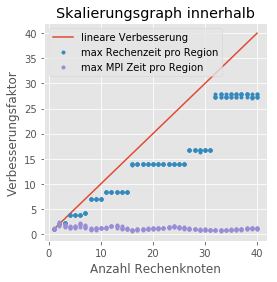

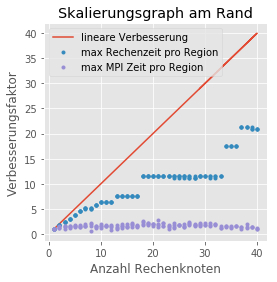

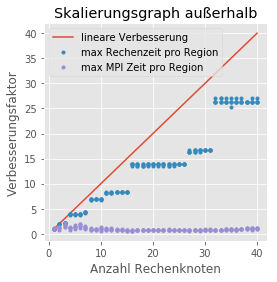

In [5]:
inside_path = './data/data_scaling_inside_mandelbrot.json'
border_path = './data/data_scaling_border_mandelbrot.json'
outside_path = './data/data_scaling_outside_mandelbrot.json'
inside = load_json(inside_path)
border = load_json(border_path)
outside = load_json(outside_path)

plt.style.use('ggplot')
simple_plot(inside, 'Skalierungsgraph innerhalb', 'scale_graph_inside')
simple_plot(border, 'Skalierungsgraph am Rand', 'scale_graph_border')
simple_plot(outside, 'Skalierungsgraph außerhalb', 'scale_graph_outside')

#regression_plot(inside)
#regression_plot(border)
#regression_plot(outside)


How does it look if we plot multiple max comp times in one plot?

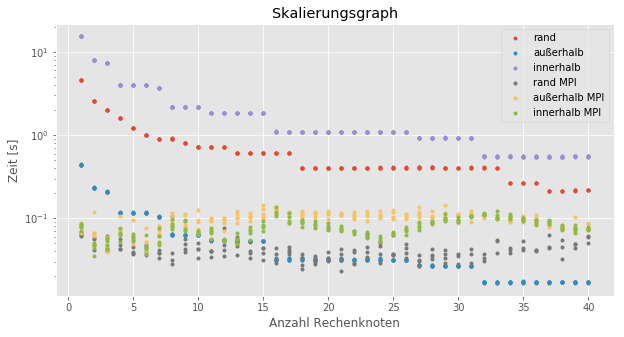

In [6]:

cpT, mpiT, nodeCnt = zip(*load_json(border_path))
cpT2, mpiT2, nodeCnt2  = zip(*load_json(outside_path))
cpT3, mpiT3, nodeCnt3  = zip(*load_json(inside_path))

x = np.asarray(nodeCnt)
x2 = np.asarray(nodeCnt2)
x3 = np.asarray(nodeCnt3)
#  time in s
cp = np.asarray(cpT) / 1e6
cp2 = np.asarray(cpT2) / 1e6
cp3 = np.asarray(cpT3) / 1e6
mpi = np.asarray(mpiT) / 1e6
mpi2 = np.asarray(mpiT2) / 1e6
mpi3 = np.asarray(mpiT3) / 1e6


fig, host = plt.subplots(figsize=(10,5))

host.plot(x, cp, label="rand", lw=0, marker=".")
host.plot(x2, cp2, label="außerhalb", lw=0, marker=".")
host.plot(x3, cp3, label="innerhalb", lw=0, marker=".")
host.plot(x, mpi, label="rand MPI", lw=0, marker=".")
host.plot(x2, mpi2, label="außerhalb MPI", lw=0, marker=".")
host.plot(x3, mpi3, label="innerhalb MPI", lw=0, marker=".")

host.set(xlabel='Anzahl Rechenknoten', ylabel='Zeit [s]',
    title='Skalierungsgraph'
)
# par1.set(ylabel='max mpi time [s]')

host.legend()
host.grid(True)
plt.yscale('log')
#plt.axis([0, None, 0, 0.04])

plt.show()

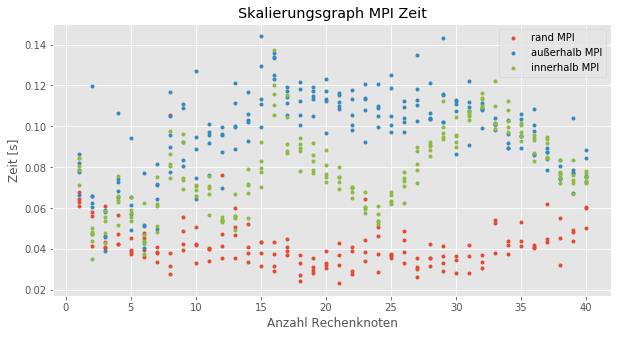

In [7]:

cpT, mpiT, nodeCnt = zip(*load_json(border_path))
cpT2, mpiT2, nodeCnt2  = zip(*load_json(outside_path))
cpT3, mpiT3, nodeCnt3  = zip(*load_json(inside_path))

x = np.asarray(nodeCnt)
x2 = np.asarray(nodeCnt2)
x3 = np.asarray(nodeCnt3)
#  time in s
cp = np.asarray(cpT) / 1e6
cp2 = np.asarray(cpT2) / 1e6
cp3 = np.asarray(cpT3) / 1e6
mpi = np.asarray(mpiT) / 1e6
mpi2 = np.asarray(mpiT2) / 1e6
mpi3 = np.asarray(mpiT3) / 1e6


fig, host = plt.subplots(figsize=(10,5))

#host.plot(x, cp, label="rand", lw=0, marker=".")
#host.plot(x2, cp2, label="außerhalb", lw=0, marker=".")
#host.plot(x3, cp3, label="innerhalb", lw=0, marker=".")
host.plot(x, mpi, label="rand MPI", lw=0, marker=".")
host.plot(x2, mpi2, label="außerhalb MPI", lw=0, marker=".", color='#348ABD')
host.plot(x3, mpi3, label="innerhalb MPI", lw=0, marker=".", color='#8EBA42')

host.set(xlabel='Anzahl Rechenknoten', ylabel='Zeit [s]',
    title='Skalierungsgraph MPI Zeit'
)
# par1.set(ylabel='max mpi time [s]')

host.legend()
host.grid(True)
#plt.yscale('log')
#plt.axis([0, None, 0, 0.04])
#save_fig(fig, 'scaling_mpi')

plt.show()

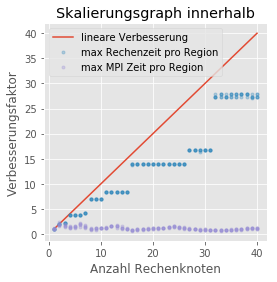

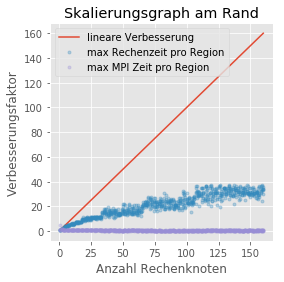

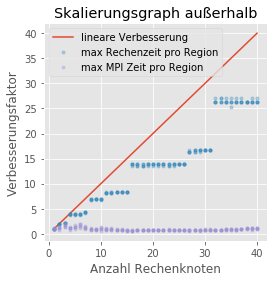

In [8]:
inside_path = './data/data_scaling_inside_mandelbrot.json'
border_path = './data/data_scaling_border_more_nodes.json'
outside_path = './data/data_scaling_outside_mandelbrot.json'
inside = load_json(inside_path)
border = load_json(border_path)
outside = load_json(outside_path)

plt.style.use('ggplot')
simple_plot(inside, 'Skalierungsgraph innerhalb', 'scale_graph_inside', alpha=0.3)
simple_plot(border, 'Skalierungsgraph am Rand', 'scale_graph_border_more_nodes', alpha=0.3)
simple_plot(outside, 'Skalierungsgraph außerhalb', 'scale_graph_outside', alpha=0.3)